In [1]:
# Constants
import string
from random import choices, choice
from datetime import datetime

INPUT_SIZE = [512, 1024, 2048, 4096]
INPUT_SIZE = [4096]
HIDDEN_LAYERS = [1, 2]
HIDDEN_LAYER_DIVISOR = [2, 4, 8]
Z_LAYER_DIVISOR = [4, 8, 16, 32]
DROPOUT = [.1, .25, .5]
LEARNING_RATE = [0.000001, 0.00001, 0.0001]
BATCH_SIZE = [8, 16, 32]
FOLLOWER = False # Set later, false for aae, true for regular

DATA_SET = "Task 2 (10% Noise)"
TYPE = "Adversarial AE"
TIME_LENGTH = 3
DIFFERENCE_THRESHS = [.8 + 0.2 * i for i in range(25)]
ATTEMPT = 0 # Set later, doesn't make a difference

# New masking section
MASKING = [False, True, True, True]
MASK_SIZE = [.25, .5, .75]

name = datetime.now().strftime("%Y%m%d%H%M%S")

model_final_stats = {"name": name, "dataset": DATA_SET, "type": TYPE, "len": TIME_LENGTH}

print(name)

20240219001731


In [2]:
# Assign whether follower or not based on the previous models attempt
import pandas as pd

# Previous failed
previous_failed = False

try:
    open("failed", "x")
except FileExistsError:
    if FOLLOWER:
        crash()
    else:
        previous_failed = True

try:
    previous_trials = pd.read_csv("ae_trials.csv").to_dict("records")
    if len(previous_trials) % 2 == 1:
        print(1)
        FOLLOWER = True
        ATTEMPT = previous_trials[-1]["attempt"]
    elif previous_trials[-1]["attempt"] == 4:
        print(2)
        FOLLOWER = False
        ATTEMPT = 0
    else:
        print(3)
        FOLLOWER = True
        ATTEMPT = previous_trials[-1]["attempt"] + 1
    
    if previous_failed:
        print("Prev Failed")
        FOLLOWER = False
        ATTEMPT = 0
        
        
except (FileNotFoundError, pd.errors.EmptyDataError):
    print(4)
    FOLLOWER = False
    ATTEMPT = 0

model_final_stats["attempt"] = ATTEMPT

1
Prev Failed


/tmp/ipykernel_595091/2516016999.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Pick hyperparameters
hyper_params = {
    "input_size": choice(INPUT_SIZE),
    "hidden_layers": choice(HIDDEN_LAYERS),
    "hidden_layers_divisor": choice(HIDDEN_LAYER_DIVISOR),
    "z_layer_divisor": choice(Z_LAYER_DIVISOR),
    "dropout": choice(DROPOUT),
    "learning_rate": choice(LEARNING_RATE),
    "batch_size": choice(BATCH_SIZE),
    "masking": choice(MASKING),
    "mask_size": choice(MASK_SIZE)
}
hyper_params["input_size"] *= TIME_LENGTH
hyper_params["hidden_layers_divisor"] *= TIME_LENGTH
hyper_params["z_layer_divisor"] *= TIME_LENGTH
model_final_stats["leader"] = None

if FOLLOWER:
    previous_models = pd.read_csv("ae_trials.csv", keep_default_na=False).to_dict("records")
    for model in previous_models[::-1]: # We want to find the original leader not a fake leader
        if not model["leader"]:
            model_final_stats["leader"] = model["name"]
            break
    
    for key in hyper_params.keys():
        hyper_params[key] = model[key]

model_final_stats.update(hyper_params)
print(model_final_stats)

{'name': '20240219001731', 'dataset': 'Task 2 (10% Noise)', 'type': 'Adversarial AE', 'len': 3, 'attempt': 0, 'leader': None, 'input_size': 12288, 'hidden_layers': 2, 'hidden_layers_divisor': 12, 'z_layer_divisor': 24, 'dropout': 0.1, 'learning_rate': 0.0001, 'batch_size': 16, 'masking': True, 'mask_size': 0.5}


In [4]:
# Load datasets
from pickle import load
from random import sample

x_tests, y_tests = load(open("data/test_%d_%d.pickle" % (model_final_stats["input_size"], model_final_stats["len"]), "rb"))
x_tests = [[x - 0.5 for x in sample] for sample in x_tests[ATTEMPT]]
y_tests = y_tests[ATTEMPT]

x_train = load(open("data/train_%d_%d.pickle" % (model_final_stats["input_size"], model_final_stats["len"]), "rb"))
x_train = [[x - 0.5 for x in sample] for sample in x_train[ATTEMPT]]

# Mask x_tests and y_tests
if hyper_params["masking"]:
    # print(int(hyper_params["input_size"] * hyper_params["mask_size"]), hyper_params["input_size"])
    # print(len(x_tests))
    x_tests = [[x, [x[i] for i in sorted(sample(range(len(x)), int(hyper_params["input_size"] * hyper_params["mask_size"])))]] for x in x_tests]
    x_train = [[x, [x[i] for i in sorted(sample(range(len(x)), int(hyper_params["input_size"] * hyper_params["mask_size"])))]] for x in x_train]

x_tests, y_tests = [x_tests], [y_tests]

In [5]:
# Create encoder model
from tensorflow.keras import models, layers

encoder = models.Sequential()

if hyper_params["masking"]:
    encoder.add(layers.Input(shape=int(hyper_params["input_size"] * hyper_params["mask_size"])))
else:
    encoder.add(layers.Input(shape=hyper_params["input_size"]))

for i in range(hyper_params["hidden_layers"]):
    encoder.add(layers.Dense(hyper_params["input_size"]//(hyper_params["hidden_layers_divisor"] * i + 1), activation="elu"))
    encoder.add(layers.Dropout(hyper_params["dropout"]))
encoder.add(layers.Dense(hyper_params["input_size"]//hyper_params["z_layer_divisor"]))

encoder.summary()

2024-02-19 00:17:32.645067: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-19 00:17:32.690962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 00:17:33.288619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12288)             75509760  
                                                                 
 dropout (Dropout)           (None, 12288)             0         
                                                                 
 dense_1 (Dense)             (None, 945)               11613105  
                                                                 
 dropout_1 (Dropout)         (None, 945)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               484352    
                                                                 
Total params: 87607217 (334.20 MB)
Trainable params: 87607217 (334.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-02-19 00:17:34.224189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22229 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9
2024-02-19 00:17:34.224719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22453 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


In [6]:
# Create decoder model
decoder = models.Sequential()
decoder.add(layers.Input(hyper_params["input_size"]//hyper_params["z_layer_divisor"]))
for i in list(range(hyper_params["hidden_layers"]))[::-1]:
    decoder.add(layers.Dense(hyper_params["input_size"]//(hyper_params["hidden_layers_divisor"] * i + 1), activation="elu"))
    decoder.add(layers.Dropout(hyper_params["dropout"]))
decoder.add(layers.Dense(hyper_params["input_size"]))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 945)               484785    
                                                                 
 dropout_2 (Dropout)         (None, 945)               0         
                                                                 
 dense_4 (Dense)             (None, 12288)             11624448  
                                                                 
 dropout_3 (Dropout)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 12288)             151007232 
                                                                 
Total params: 163116465 (622.24 MB)
Trainable params: 163116465 (622.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Create autoencoder model
autoencoder = models.Sequential()

if hyper_params["masking"]:
    autoencoder.add(layers.Input(shape=int(hyper_params["input_size"] * hyper_params["mask_size"])))
else:
    autoencoder.add(layers.Input(shape=hyper_params["input_size"]))

autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512)               87607217  
                                                                 
 sequential_1 (Sequential)   (None, 12288)             163116465 
                                                                 
Total params: 250723682 (956.43 MB)
Trainable params: 250723682 (956.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Create discriminator
discriminator = models.Sequential()
discriminator.add(layers.Input(shape=hyper_params["input_size"]//hyper_params["z_layer_divisor"]))
for i in list(range(hyper_params["hidden_layers"]))[::-1]:
    discriminator.add(layers.Dense(hyper_params["input_size"]//(hyper_params["hidden_layers_divisor"] * i + 1), activation="elu"))
    discriminator.add(layers.Dropout(hyper_params["dropout"]))
discriminator.add(layers.Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 945)               484785    
                                                                 
 dropout_4 (Dropout)         (None, 945)               0         
                                                                 
 dense_7 (Dense)             (None, 12288)             11624448  
                                                                 
 dropout_5 (Dropout)         (None, 12288)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 12289     
                                                                 
Total params: 12121522 (46.24 MB)
Trainable params: 12121522 (46.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.models import clone_model
import tensorflow as tf
import numpy as np

ae_opt = optimizers.Adam(learning_rate=hyper_params["learning_rate"])
gen_opt = optimizers.Adam(learning_rate=hyper_params["learning_rate"])
disc_opt = optimizers.Adam(learning_rate=hyper_params["learning_rate"])

bin_cross_entropy = BinaryCrossentropy(from_logits=False)
mse = MeanSquaredError()

def generate_real_z(percent_normal, variance, batch_length):
    z_normal = np.random.randn(batch_length, hyper_params["input_size"]//hyper_params["z_layer_divisor"])
    z_random = np.random.rand(batch_length, hyper_params["input_size"]//hyper_params["z_layer_divisor"]) * variance * 3
    z = percent_normal * z_normal * variance
    return z + (1 - percent_normal) * (z_random - ( 0.5 * variance * 3))

def discriminator_loss(real, fake):
    return bin_cross_entropy(np.zeros_like(fake), fake) + bin_cross_entropy(np.ones_like(real), real)

def generator_loss(fake):
    return bin_cross_entropy(np.ones_like(fake), fake)

def train_batch(batch_x, batch_y=None):
    global autoencoder # for whatever reason, train_epochs needs these and I didn't see a point in only adding it to one
    global discriminator
    global generator
    
    with tf.GradientTape() as ae_tape:
        ae_predict = autoencoder(batch_x, training=True)

        if batch_y is not None:
            ae_loss = mse(batch_y, ae_predict)
        else:
            ae_loss = mse(batch_x, ae_predict)
    
    gradient_ae = ae_tape.gradient(ae_loss, autoencoder.trainable_variables)
    ae_opt.apply_gradients(zip(gradient_ae, autoencoder.trainable_variables))
    
    with tf.GradientTape() as disc_tape:
        fake_dist = encoder(batch_x, training=True)
        real_dist = generate_real_z(1, 5, len(batch_x))
        
        real_out = discriminator(real_dist, training=True)
        fake_out = discriminator(fake_dist, training=True)

        disc_loss = discriminator_loss(real_out, fake_out)

    gradient_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_opt.apply_gradients(zip(gradient_disc, discriminator.trainable_variables))
    
    with tf.GradientTape() as gen_tape:
        fake_dist = encoder(batch_x, training=True)
        real_dist = generate_real_z(1, 5, len(batch_x))
        
        real_out = discriminator(real_dist, training=True)
        fake_out = discriminator(fake_dist, training=True)

        gen_loss = generator_loss(fake_out)

    gradient_gen = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    gen_opt.apply_gradients(zip(gradient_gen, encoder.trainable_variables))

def train_epochs(x_train, epochs, batch_size, validation_split=0, memory_for_earlystopping=-1):
    # Saves every x epochs, where x is save and is greater than 0
    
    global autoencoder # for whatever reason, it needs these
    global discriminator
    global generator
    
    return_dict = {}
    
    if validation_split > 0:
        validation_split = int(len(x_train) * validation_split)
        x_val = x_train[:validation_split]
        
        if hyper_params["masking"]:
            y_val = [x[0] for x in x_val]
            y_val = np.array(y_val).reshape(validation_split, hyper_params["input_size"])
            
            x_val = [x[1] for x in x_val]
            x_val = np.array(x_val).reshape(validation_split, int(hyper_params["input_size"] * hyper_params["mask_size"]))
        else:
            x_val = np.array(x_val).reshape(validation_split, hyper_params["input_size"])
        
        x_train = x_train[validation_split:]
        return_dict["ae_loss"] = []
        return_dict["disc_loss"] = []
        return_dict["gen_loss"] = []
    
    number_of_batches = len(x_train)//batch_size
    
    if memory_for_earlystopping != -1:
            return_dict["saves"] = []
    
    shuffle(x_train)
    batches = [x_train[b::number_of_batches] for b in range(number_of_batches)]

    if hyper_params["masking"]:
        batches_x = [[x[1] for x in b] for b in batches]
        batches_x = [np.array(b).reshape(len(b), int(hyper_params["input_size"] * hyper_params["mask_size"])) for b in batches_x]
        
        batches_y = [[x[0] for x in b] for b in batches]
        batches_y = [np.array(b).reshape(len(b), hyper_params["input_size"]) for b in batches_y]
    else:
        batches = [np.array(b).reshape(len(b), hyper_params["input_size"]) for b in batches]
    
    for e in range(epochs):
        print("Epoch %s Running..." % (e), end="")

        if hyper_params["masking"]:
            for bx, by in zip(batches_x, batches_y):
                train_batch(bx, batch_y=by)
        else:
            for b in batches:
                train_batch(b)
        
        if validation_split > 0:
            ae_predict = autoencoder(x_val)
            if hyper_params["masking"]:
                ae_loss = mse(y_val, ae_predict)
            else:
                ae_loss = mse(x_val, ae_predict)
            return_dict["ae_loss"].append(ae_loss.numpy())
            print("Done; AE Loss: %s" % return_dict["ae_loss"][-1], end="; ")
            
            fake_dist = encoder(x_val)
            real_dist = 10 * np.random.randn(len(x_val), hyper_params["input_size"]//hyper_params["z_layer_divisor"])
        
            real_out = discriminator(real_dist)
            fake_out = discriminator(fake_dist)

            disc_loss = discriminator_loss(real_out, fake_out)
            gen_loss = generator_loss(fake_out)
            return_dict["disc_loss"].append(disc_loss.numpy())
            return_dict["gen_loss"].append(gen_loss.numpy())
            print("Disc Loss: %s; Gen Loss: %s" % (return_dict["disc_loss"][-1], return_dict["gen_loss"][-1]))
        else:
            print("Done;")
        
        if memory_for_earlystopping != -1:
            if len(return_dict["saves"]) == memory_for_earlystopping and return_dict["ae_loss"][-1] > return_dict["saves"][0][0] and min([v[0] for v in return_dict["saves"]]) == return_dict["saves"][0][0]:
                best_model = return_dict["saves"][0]
                autoencoder = best_model[1]
                discriminator = best_model[2]
                del return_dict["ae_loss"][-1 * memory_for_earlystopping:]
                del return_dict["disc_loss"][-1 * memory_for_earlystopping:]
                del return_dict["gen_loss"][-1 * memory_for_earlystopping:]
                break;
            else:
                return_dict["saves"].append((return_dict["ae_loss"][-1], clone_model(autoencoder), clone_model(discriminator)))
                if len(return_dict["saves"]) > memory_for_earlystopping:
                    del return_dict["saves"][0]
    return return_dict

Epoch 0 Running...

2024-02-19 00:17:35.053761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-19 00:17:35.169976: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xc484be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-19 00:17:35.169998: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-02-19 00:17:35.170003: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-02-19 00:17:35.174726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-19 00:17:35.186696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-02-19 00:17

Done; AE Loss: 0.020466458; Disc Loss: 1.1838421; Gen Loss: 0.38795128
Epoch 1 Running...Done; AE Loss: 0.017290339; Disc Loss: 0.89538896; Gen Loss: 0.53178185
Epoch 2 Running...Done; AE Loss: 0.014698354; Disc Loss: 0.5378159; Gen Loss: 0.8897446
Epoch 3 Running...Done; AE Loss: 0.01491691; Disc Loss: 1.0164465; Gen Loss: 0.52954406
Epoch 4 Running...Done; AE Loss: 0.0133076655; Disc Loss: 1.4878066; Gen Loss: 0.36558694
Epoch 5 Running...Done; AE Loss: 0.013843907; Disc Loss: 1.7283589; Gen Loss: 0.29297838
Epoch 6 Running...Done; AE Loss: 0.01307158; Disc Loss: 1.5907323; Gen Loss: 0.36893117
Epoch 7 Running...Done; AE Loss: 0.0168849; Disc Loss: 2.8095918; Gen Loss: 0.21120684
Epoch 8 Running...Done; AE Loss: 0.012447534; Disc Loss: 5.693342; Gen Loss: 0.13984686
Epoch 9 Running...Done; AE Loss: 0.011274374; Disc Loss: 3.7123966; Gen Loss: 0.13002932
Epoch 10 Running...Done; AE Loss: 0.015540537; Disc Loss: 3.980602; Gen Loss: 0.21797128
Epoch 11 Running...Done; AE Loss: 0.0122170

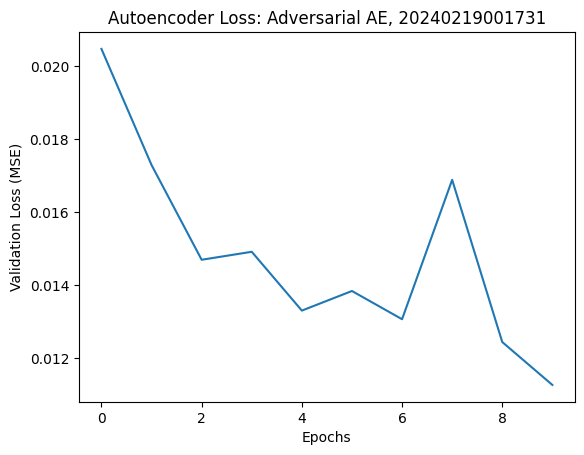

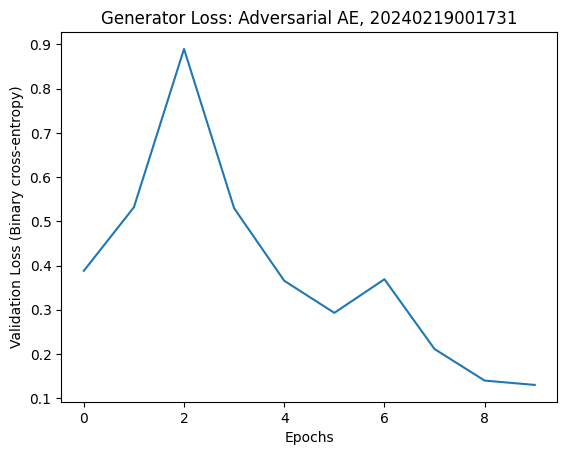

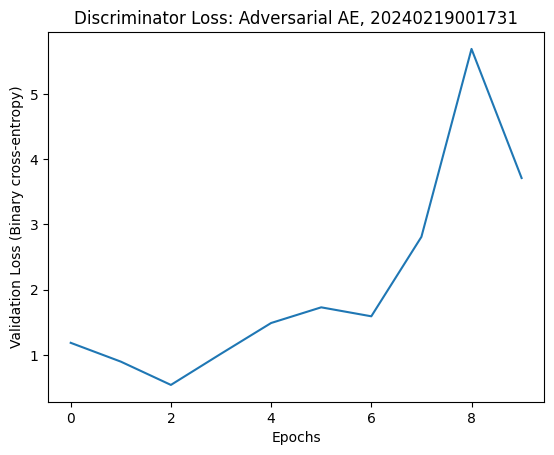

In [10]:
# Fit model and save weights
import matplotlib.pyplot as plt
from random import shuffle

fit_run = train_epochs(
    x_train, 300, hyper_params["batch_size"],
    validation_split=0.1, memory_for_earlystopping=5
)

autoencoder.save_weights("ae_saved/%s" % name)
discriminator.save_weights("ae_saved/disc_%s" % name)
final_loss = fit_run["ae_loss"][-1]

ae_res = {"gen_loss": fit_run["gen_loss"][-1], "disc_loss": fit_run["disc_loss"][-1], "val_loss": final_loss, "epochs": len(fit_run["ae_loss"])}
model_final_stats.update(ae_res)

print(ae_res)
plt.plot(range(len(fit_run["ae_loss"])), fit_run["ae_loss"])
plt.title("Autoencoder Loss: %s, %s" % (TYPE, name))
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (MSE)")
plt.show()

plt.plot(range(len(fit_run["gen_loss"])), fit_run["gen_loss"])
plt.title("Generator Loss: %s, %s" % (TYPE, name))
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (Binary cross-entropy)")
plt.show()

plt.plot(range(len(fit_run["disc_loss"])), fit_run["disc_loss"])
plt.title("Discriminator Loss: %s, %s" % (TYPE, name))
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (Binary cross-entropy)")
plt.show()

In [11]:
# Save splits of z layers, run difference classifier
from sklearn.metrics import precision_recall_fscore_support
from statistics import mean

# Copied from latent layer classifiers
def save_results(name, hyper_params, metrics, model_name, auc=False):
    try:
        previous_trials = pd.read_csv("latent_trials.csv").to_dict("records")
    except (FileNotFoundError, pd.errors.EmptyDataError):
        previous_trials = []

    model_final_stats = {"Classifier": name, "Based on AE": model_name}
    model_final_stats.update(hyper_params)
    
    model_final_stats["precision"] = metrics[0]
    model_final_stats["recall"] = metrics[1]
    model_final_stats["f-score"] = metrics[2]
    
    if auc:
        model_final_stats["auc"] = metrics[3]
    
    previous_trials.append(model_final_stats)
    pd.DataFrame(previous_trials).to_csv("latent_trials.csv", index=None)
    
    print(model_final_stats)

for split, x_test, y_test in zip(range(len(x_tests)), x_tests, y_tests):

    if hyper_params["masking"]:
        z_layers = encoder.predict(np.array([x[1] for x in x_test]).reshape(len(x_test), int(hyper_params["input_size"] * hyper_params["mask_size"])))
    else:
        z_layers = encoder.predict(np.array(x_test).reshape(len(x_test), hyper_params["input_size"]))
    
    outputs = decoder.predict(z_layers).tolist()
    print(y_test[0])
    class_true = [[np.argmax(y)] for y in y_test]
    
    z_layers = [y + z.tolist() for z, y in zip(z_layers, class_true)]
    pd.DataFrame(z_layers).to_pickle("z_layers/%s.pickle.gzip" % (name))
    print("Saved z-layers for %s" % split)
    
    for i, sigma in enumerate(DIFFERENCE_THRESHS):
        results = [[], []]
        for y_pred, y_true, y_class in zip(outputs, x_test, class_true):
            results[0].append(y_class)
            results[1].append(1 if mse(y_pred, y_true[0]).numpy() > sigma * final_loss else 0)
        save_results("ReconstructionThreshold", {"sigma": sigma}, list(precision_recall_fscore_support(results[0], results[1], average="binary"))[:3], name)
    print("Done with split %s" % split)

1/1 [==============================] - 0s 41ms/step
(1, 0)
Saved z-layers for 0
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 0.8, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 1.0, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 1.2000000000000002, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 1.4000000000000001, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 1.6, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 1.8, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 2.0, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 2.2, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 2.4000000000000004, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 2.6, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 2.8, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 3.0, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 3.2, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 3.4000000000000004, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 3.6000000000000005, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 3.8, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 4.0, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 4.2, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 4.4, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 4.6000000000000005, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 4.8, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 5.0, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 5.2, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 5.4, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240219001731', 'sigma': 5.6000000000000005, 'precision': 0.0, 'recall': 0.0, 'f-score': 0.0}
Done with split 0


/home/ian/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 23ms/step


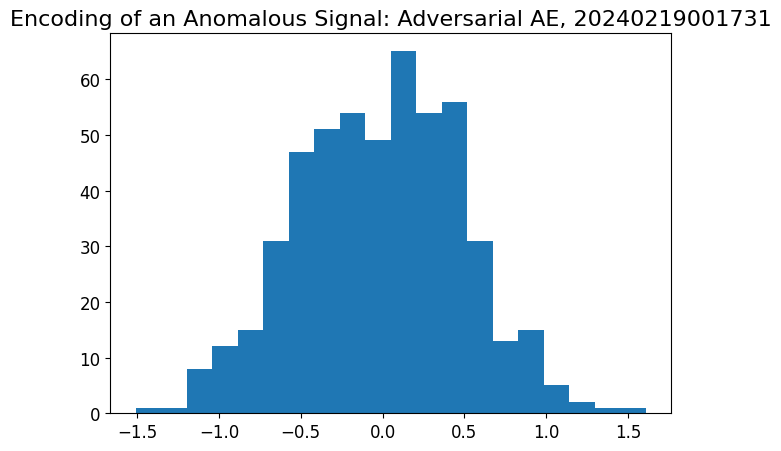

1/1 [==============================] - 0s 21ms/step


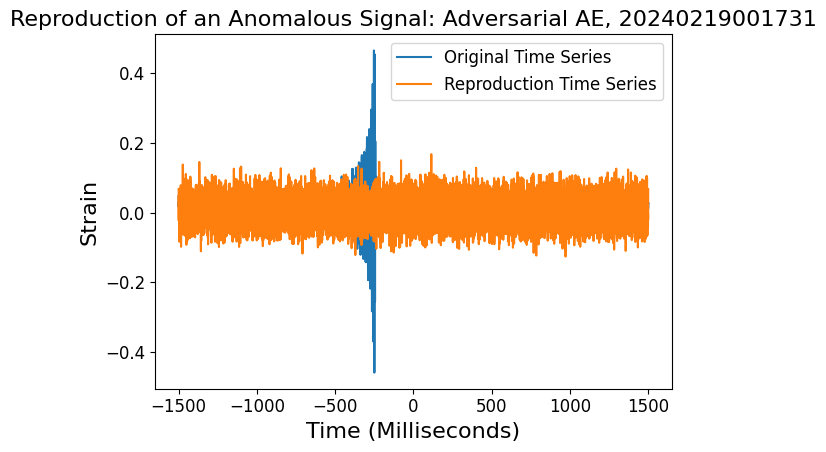

1/1 [==============================] - 0s 18ms/step


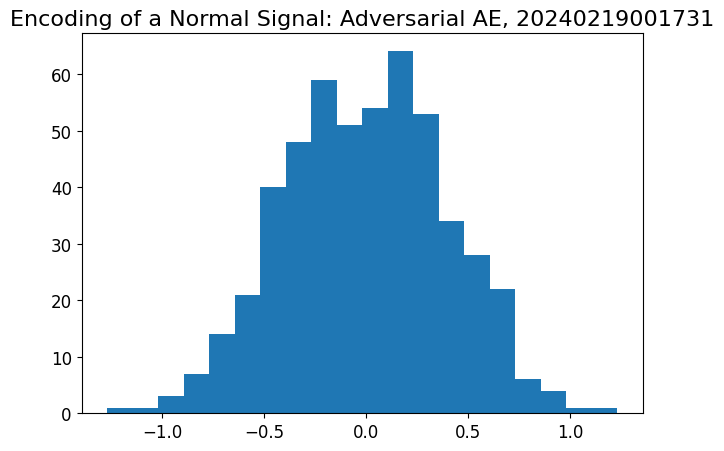

1/1 [==============================] - 0s 17ms/step


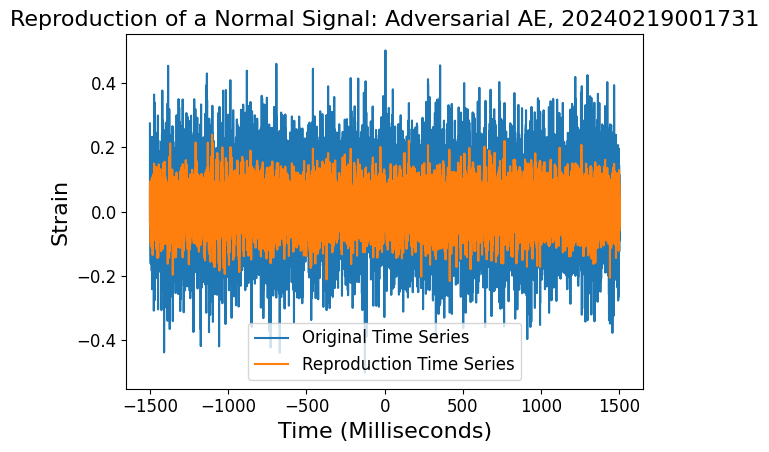

1/1 [==============================] - 0s 17ms/step


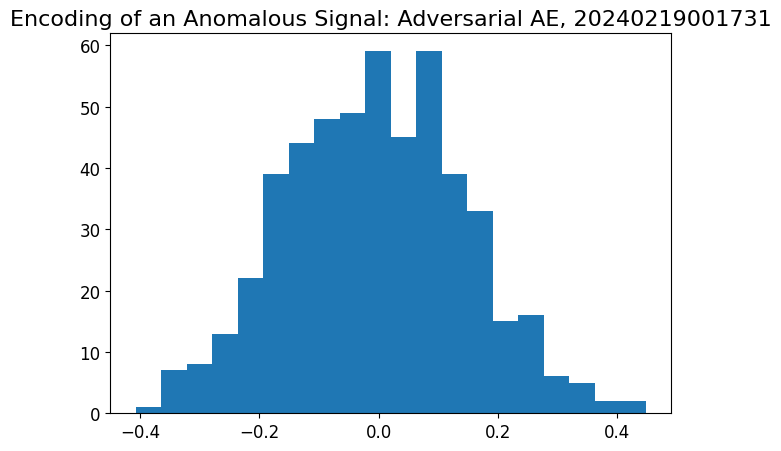

1/1 [==============================] - 0s 17ms/step


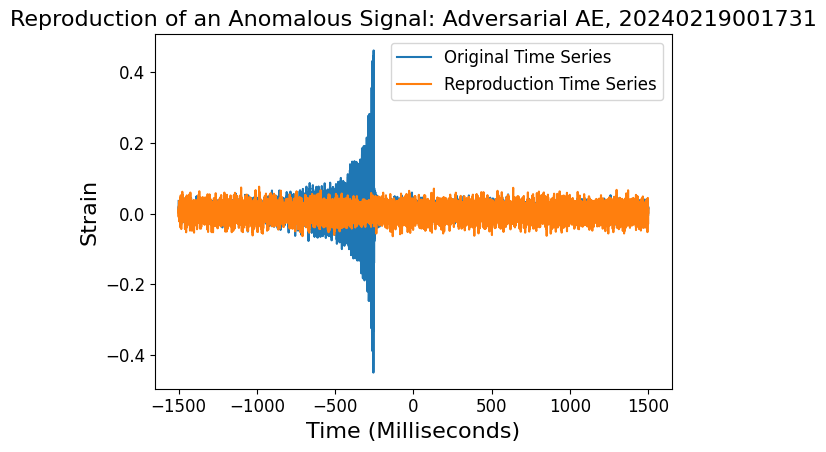

1/1 [==============================] - 0s 17ms/step


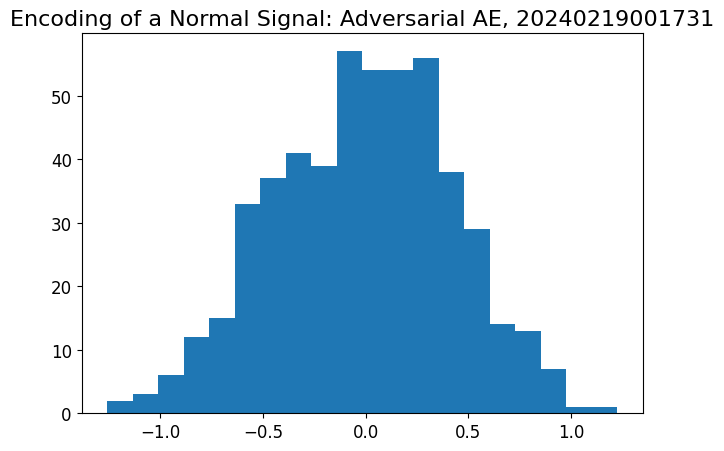

1/1 [==============================] - 0s 17ms/step


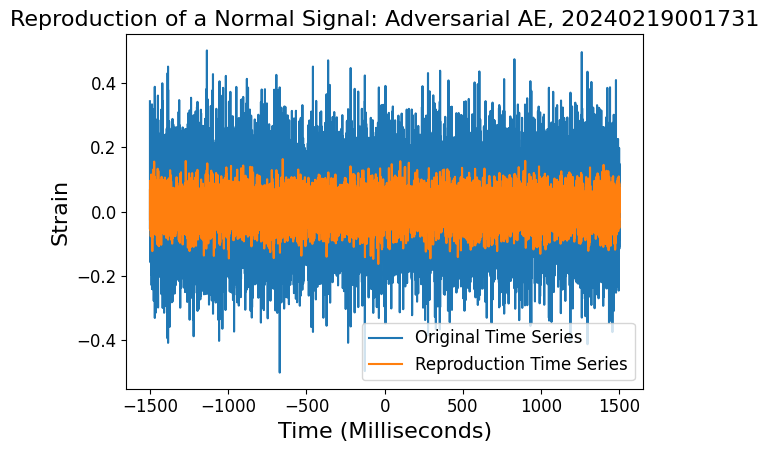

1/1 [==============================] - 0s 18ms/step


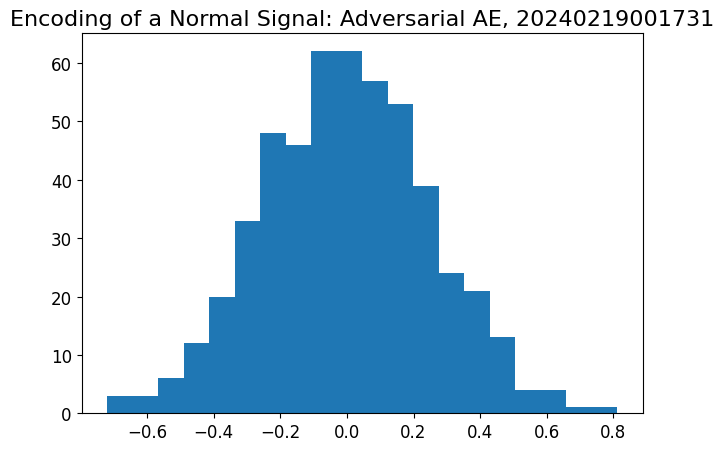

1/1 [==============================] - 0s 17ms/step


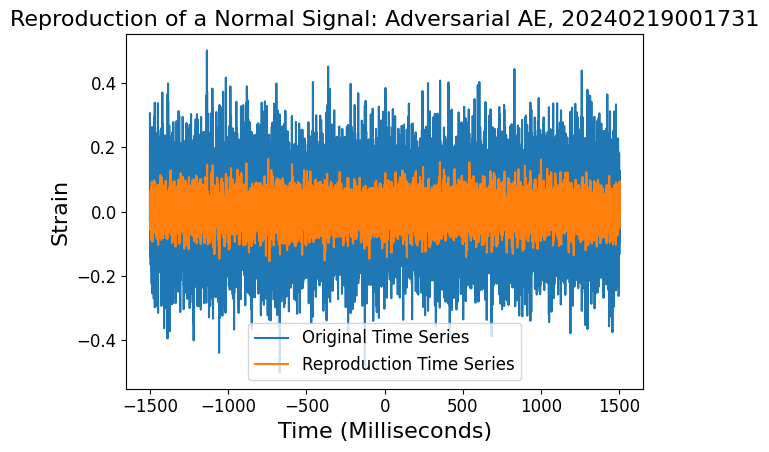

1/1 [==============================] - 0s 18ms/step


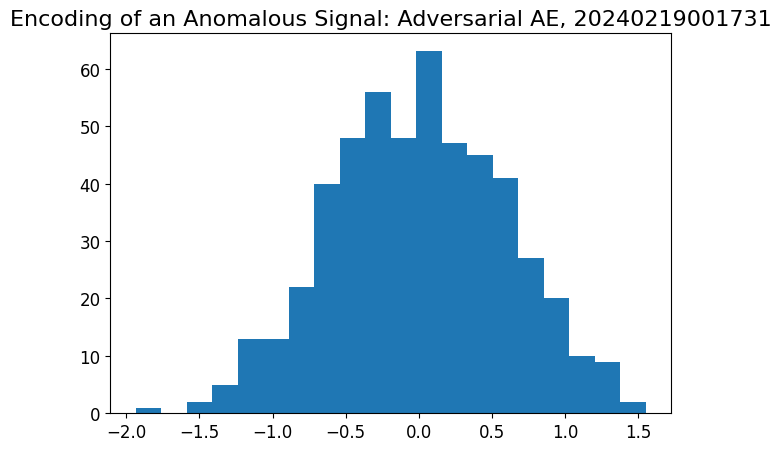

1/1 [==============================] - 0s 18ms/step


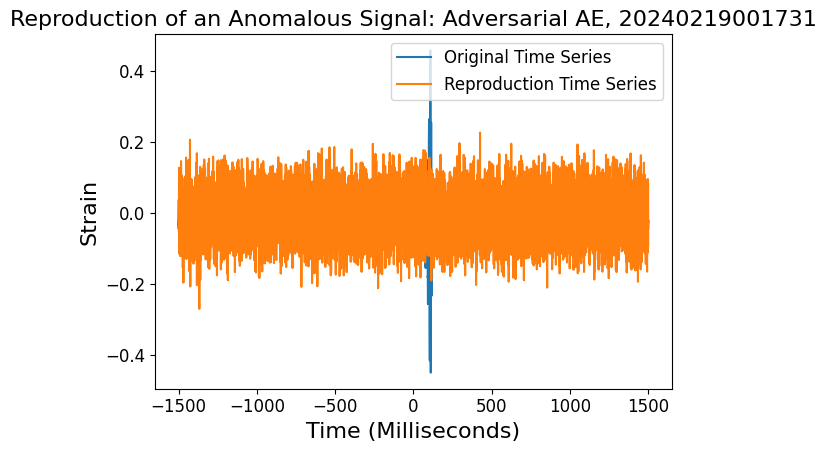

1/1 [==============================] - 0s 18ms/step


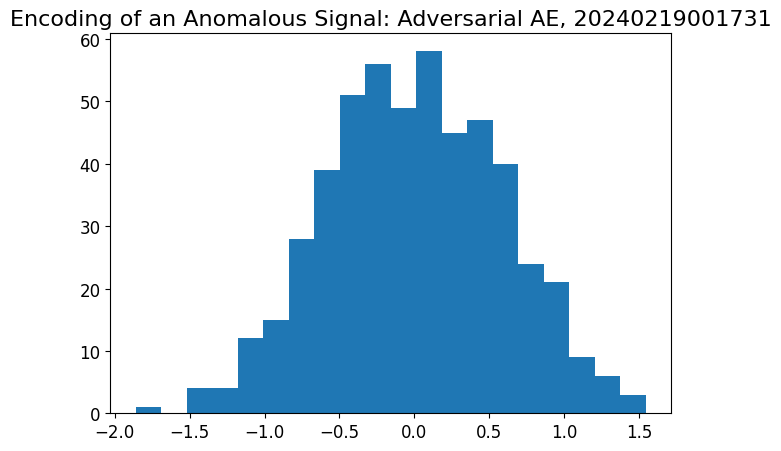

1/1 [==============================] - 0s 17ms/step


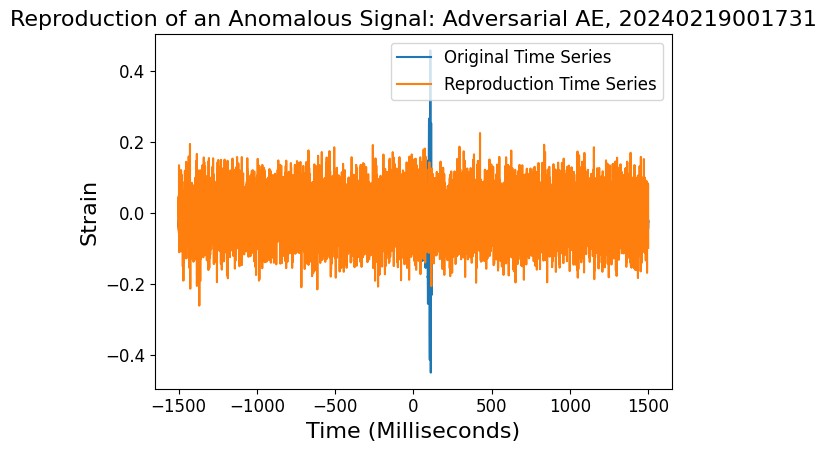

1/1 [==============================] - 0s 18ms/step


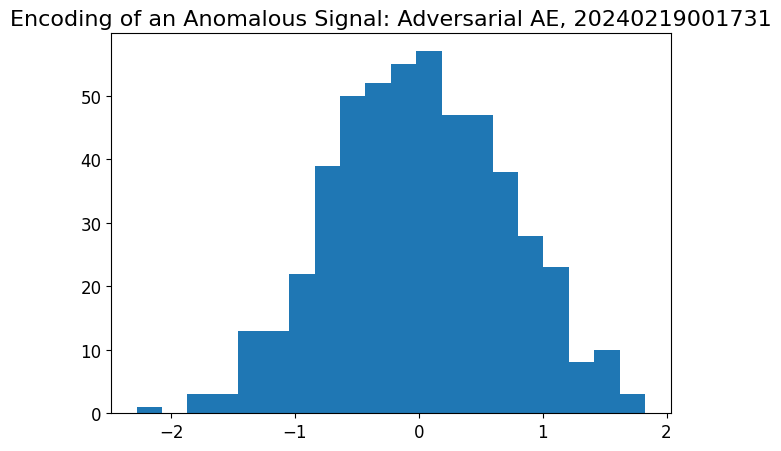

1/1 [==============================] - 0s 17ms/step


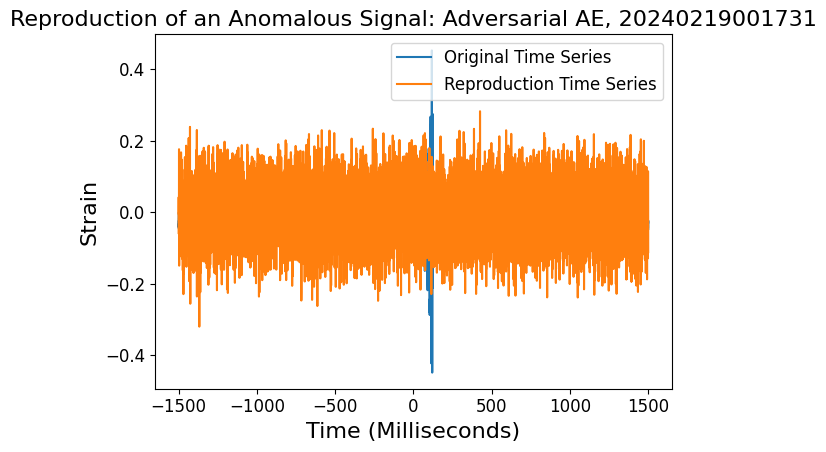

1/1 [==============================] - 0s 18ms/step


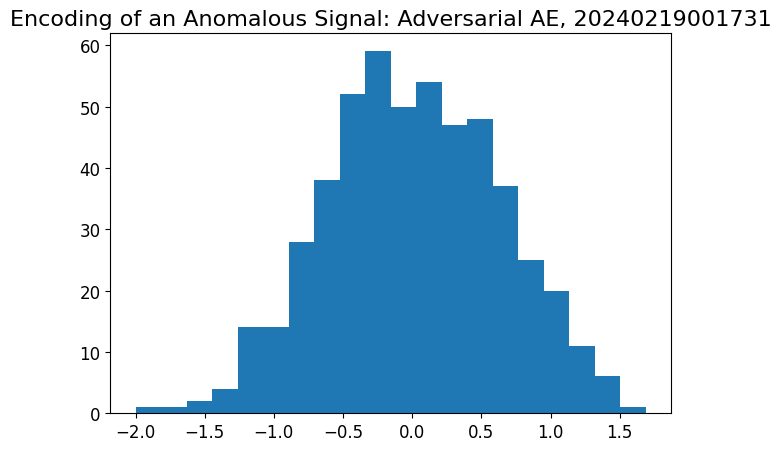

1/1 [==============================] - 0s 17ms/step


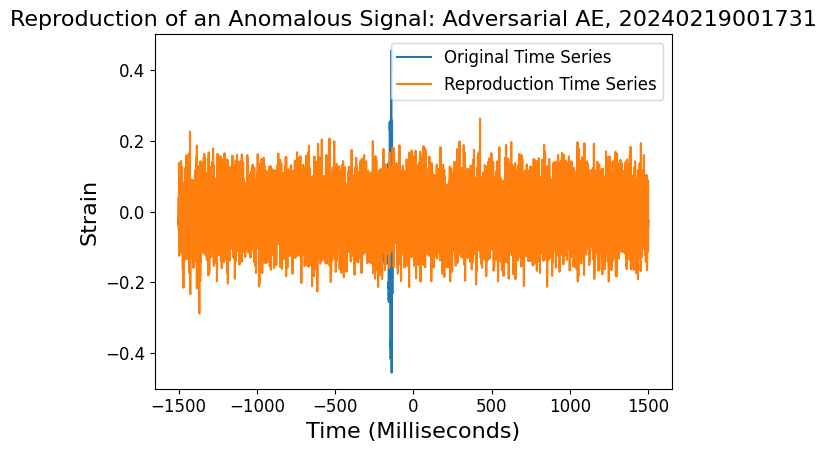

1/1 [==============================] - 0s 18ms/step


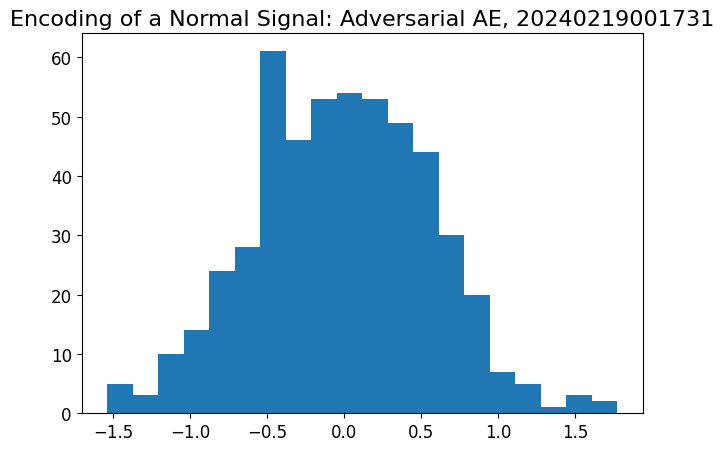

1/1 [==============================] - 0s 17ms/step


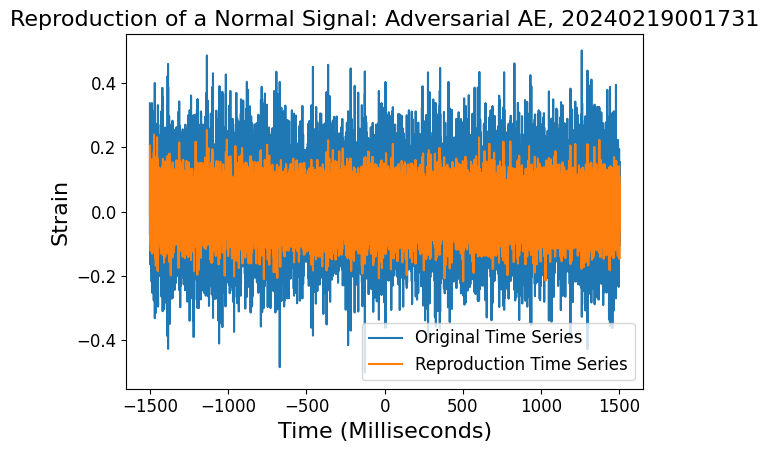

In [12]:
# Plot five graphs

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=MEDIUM_SIZE)
plt.rc("axes", titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

tests_for_graph = [(x, y) for x, y in zip(x_tests[0], y_tests[0])]
shuffle(tests_for_graph)

for x, y in tests_for_graph[:10]:
    if hyper_params["masking"]:
        encoded_x = encoder.predict(np.array(x[1]).reshape(1, int(hyper_params["input_size"] * hyper_params["mask_size"])))
    else:
        encoded_x = encoder.predict(np.array(x).reshape(1, hyper_params["input_size"]))
    
    plt.hist(encoded_x.tolist()[0], bins=20)
    plt.title("Encoding of a%s: %s, %s" % ("n Anomalous Signal" if np.argmax(y) == 1 else " Normal Signal", TYPE, name))
    plt.tight_layout()
    plt.show()

    if hyper_params["masking"]:
        plt.plot([(v - (0.5 * len(x[0])))/4.096 for v in range(len(x[0]))], x[0], label="Original Time Series")
        plt.plot([(v - (0.5 * len(x[0])))/4.096 for v in range(len(x[0]))], decoder.predict(encoded_x).tolist()[0], label="Reproduction Time Series")
    else:
        plt.plot([(v - (0.5 * len(x)))/4.096 for v in range(len(x))], x, label="Original Time Series")
        plt.plot([(v - (0.5 * len(x)))/4.096 for v in range(len(x))], decoder.predict(encoded_x).tolist()[0], label="Reproduction Time Series")
    
    plt.legend()
    plt.title("Reproduction of a%s: %s, %s" % ("n Anomalous Signal" if np.argmax(y) == 1 else " Normal Signal", TYPE, name))
    plt.xlabel("Time (Milliseconds)")
    plt.ylabel("Strain")
    plt.tight_layout()
    plt.show()

In [13]:
# Save data to file

try:
    previous_trials = pd.read_csv("ae_trials.csv").to_dict("records")
except (FileNotFoundError, pd.errors.EmptyDataError):
    previous_trials = []

previous_trials.append(model_final_stats)
pd.DataFrame(previous_trials).to_csv("ae_trials.csv", index=None)

In [14]:
# Remove Temp Lock
import os

os.remove("failed")